🔥  Создание виртуального коуча:

        Спринт 1. Построение каркаса позы через ключевые точки.
        Спринт 2. Оценка сходства поз по фотографии.
        Спринт 3. Валидация оценки позы на видео.
        Спринт 4. Разработка своего виртуального коуча.
        Спринт 5. Подготовка к презентации проекта.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


🎯 Первый спринт нашего проекта посвящён оценке ориентации человека в графическом формате (Human Pose Skeleton).

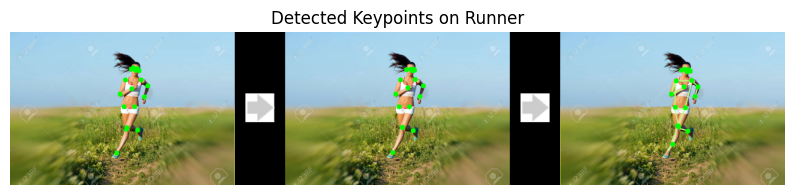

In [ ]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights

# Указываем устройство (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Загружаем предобученную модель
weights = KeypointRCNN_ResNet50_FPN_Weights.COCO_V1
model = keypointrcnn_resnet50_fpn(weights=weights)
model.to(device)
model.eval()

# Опорные точки тела
keypoints_labels = [
    "nose", "left_eye", "right_eye", "left_ear", "right_ear",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist", "left_hip", "right_hip",
    "left_knee", "right_knee", "left_ankle", "right_ankle"
]

# Загружаем изображение
image_path = "/content/drive/My Drive/Fitness/Image1.png"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Трансформируем изображение
transform = T.Compose([T.ToTensor()])
image_tensor = transform(image_rgb).unsqueeze(0).to(device)

# Запускаем предсказание
with torch.no_grad():
    prediction = model(image_tensor)

# Извлекаем ключевые точки и уверенности
keypoints = prediction[0]['keypoints'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()
conf_threshold = 0.9

# Фильтруем ключевые точки с высокой уверенностью
filtered_keypoints = keypoints[scores > conf_threshold]

# Функция для отрисовки ключевых точек
def draw_keypoints(img, keypoints):
    img_copy = img.copy()
    for keypoint_set in keypoints:
        for kp in keypoint_set:
            x, y, v = kp
            if v > 0:  # Проверяем, что точка видима
                cv2.circle(img_copy, (int(x), int(y)), 5, (0, 255, 0), -1)
    return img_copy

# Рисуем ключевые точки
image_with_keypoints = draw_keypoints(image_rgb, filtered_keypoints)

# Отображаем результат
plt.figure(figsize=(10, 5))
plt.imshow(image_with_keypoints)
plt.axis("off")
plt.title("Detected Keypoints on Runner")
plt.show()

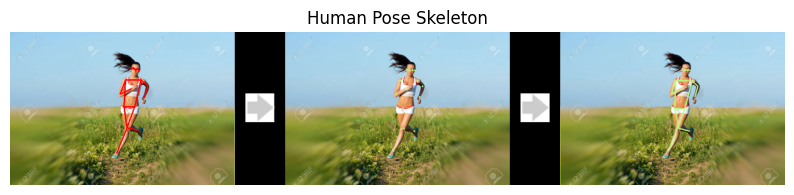

In [ ]:
# Функция для отрисовки каркаса (Skeleton) на основе ключевых точек
def draw_skeleton(img, keypoints, limbs):
    img_copy = img.copy()
    for limb in limbs:
        pt1 = tuple(map(int, keypoints[limb[0], :2]))  # Первая точка конечности
        pt2 = tuple(map(int, keypoints[limb[1], :2]))  # Вторая точка конечности
        cv2.line(img_copy, pt1, pt2, (255, 0, 0), 2)  # Рисуем линию (синий цвет)
    return img_copy

# Получаем список конечностей (limbs)
limbs = [
    [keypoints_labels.index("right_eye"), keypoints_labels.index("nose")],
    [keypoints_labels.index("right_eye"), keypoints_labels.index("right_ear")],
    [keypoints_labels.index("left_eye"), keypoints_labels.index("nose")],
    [keypoints_labels.index("left_eye"), keypoints_labels.index("left_ear")],
    [keypoints_labels.index("right_shoulder"), keypoints_labels.index("right_elbow")],
    [keypoints_labels.index("right_elbow"), keypoints_labels.index("right_wrist")],
    [keypoints_labels.index("left_shoulder"), keypoints_labels.index("left_elbow")],
    [keypoints_labels.index("left_elbow"), keypoints_labels.index("left_wrist")],
    [keypoints_labels.index("right_hip"), keypoints_labels.index("right_knee")],
    [keypoints_labels.index("right_knee"), keypoints_labels.index("right_ankle")],
    [keypoints_labels.index("left_hip"), keypoints_labels.index("left_knee")],
    [keypoints_labels.index("left_knee"), keypoints_labels.index("left_ankle")],
    [keypoints_labels.index("right_shoulder"), keypoints_labels.index("left_shoulder")],
    [keypoints_labels.index("right_hip"), keypoints_labels.index("left_hip")],
    [keypoints_labels.index("right_shoulder"), keypoints_labels.index("right_hip")],
    [keypoints_labels.index("left_shoulder"), keypoints_labels.index("left_hip")],
]

# Отрисовываем каркас (Skeleton) на изображении
image_with_skeleton = draw_skeleton(image_rgb, filtered_keypoints[0], limbs)

# Отображаем результат
plt.figure(figsize=(10, 5))
plt.imshow(image_with_skeleton)
plt.axis("off")
plt.title("Human Pose Skeleton")
plt.show()

🎯 Теперь можно переходить к Спринту 2 – Оценка сходства поз по фотографии.

В этом спринте мы будем:

🔹 Сравнивать позы людей на изображениях.

🔹 Использовать метрики сходства (например, косинусное сходство или L2-норму).

🔹 Определять, насколько точно человек повторяет заданную позу.

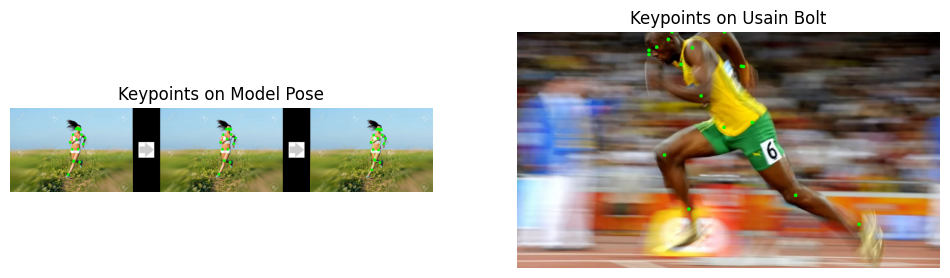

In [ ]:
# Обновленные пути к изображениям
image_path_model = "/content/drive/My Drive/Fitness/Image1.png"  # Модельная поза (девушка)
image_path_bolt = "/content/drive/My Drive/Fitness/Image2.jpg"  # Усэйн Болт

# Функция для загрузки и обработки изображения
def process_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(image_rgb).unsqueeze(0).to(device)

    # Запускаем предсказание
    with torch.no_grad():
        prediction = model(image_tensor)

    # Извлекаем ключевые точки и уверенности
    keypoints = prediction[0]['keypoints'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    conf_threshold = 0.9

    # Фильтруем ключевые точки с высокой уверенностью
    filtered_keypoints = keypoints[scores > conf_threshold]

    return image_rgb, filtered_keypoints

# Обрабатываем оба изображения
image_rgb_model, filtered_keypoints_model = process_image(image_path_model)
image_rgb_bolt, filtered_keypoints_bolt = process_image(image_path_bolt)

# Визуализируем ключевые точки
def draw_keypoints(img, keypoints):
    img_copy = img.copy()
    for keypoint_set in keypoints:
        for kp in keypoint_set:
            x, y, v = kp
            if v > 0:  # Проверяем, что точка видима
                cv2.circle(img_copy, (int(x), int(y)), 5, (0, 255, 0), -1)
    return img_copy

# Рисуем ключевые точки на обоих изображениях
image_with_keypoints_model = draw_keypoints(image_rgb_model, filtered_keypoints_model)
image_with_keypoints_bolt = draw_keypoints(image_rgb_bolt, filtered_keypoints_bolt)

# Отображаем результаты
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image_with_keypoints_model)
ax[0].set_title("Keypoints on Model Pose")
ax[0].axis("off")

ax[1].imshow(image_with_keypoints_bolt)
ax[1].set_title("Keypoints on Usain Bolt")
ax[1].axis("off")

plt.show()

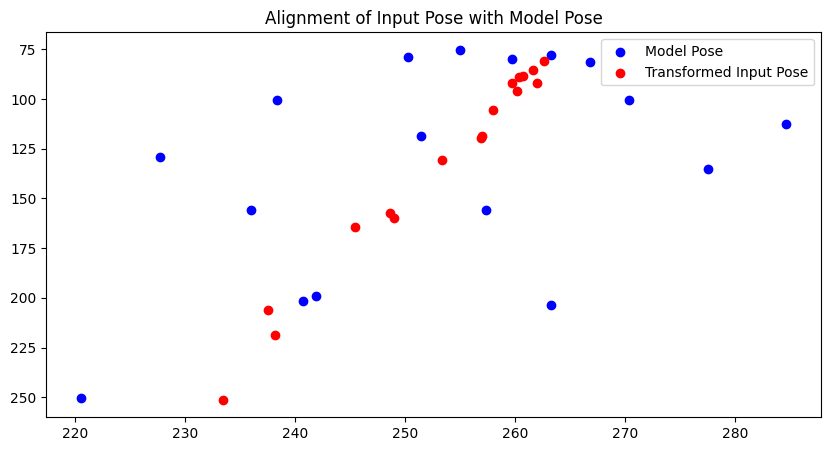

In [ ]:
# Функция для выполнения аффинного преобразования (наложение Прокруста)
def procrustes_analysis(model_keypoints, input_keypoints):
    """
    Применяет аффинное преобразование к входным ключевым точкам,
    чтобы они лучше соответствовали модельным.
    """
    # Расширяем точки до формата [[x, y, 1], ...]
    pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
    unpad = lambda x: x[:, :-1]

    Y = pad(model_keypoints)  # Модельные точки
    X = pad(input_keypoints)  # Входные точки

    # Решаем систему уравнений X * A = Y (методом наименьших квадратов)
    A, res, rank, s = np.linalg.lstsq(X, Y, rcond=None)

    # Обнуляем слишком маленькие значения
    A[np.abs(A) < 1e-10] = 0

    # Функция для применения найденного преобразования
    transform = lambda x: unpad(np.dot(pad(x), A))
    input_transformed = transform(input_keypoints)

    return input_transformed

# Выбираем только (x, y) из найденных ключевых точек
model_keypoints = filtered_keypoints_model[0][:, :2]  # Модельная поза (девушка)
input_keypoints = filtered_keypoints_bolt[0][:, :2]  # Входная поза (Болт)

# Применяем аффинное преобразование
input_transformed = procrustes_analysis(model_keypoints, input_keypoints)

# Визуализируем результат
plt.figure(figsize=(10, 5))
plt.scatter(model_keypoints[:, 0], model_keypoints[:, 1], color="blue", label="Model Pose")
plt.scatter(input_transformed[:, 0], input_transformed[:, 1], color="red", label="Transformed Input Pose")
plt.legend()
plt.gca().invert_yaxis()  # Инвертируем ось Y, так как изображения используют верхний левый угол как (0,0)
plt.title("Alignment of Input Pose with Model Pose")
plt.show()

In [ ]:
# Теперь запускаем расчёт метрик сравнения поз
def cosine_similarity(pose1, pose2):
    pose1_flat = pose1.flatten()
    pose2_flat = pose2.flatten()

    cos_sim = np.dot(pose1_flat, pose2_flat) / (np.linalg.norm(pose1_flat) * np.linalg.norm(pose2_flat))
    return cos_sim

def weighted_similarity(pose1, pose2, conf1):
    sum1 = 1 / np.sum(conf1)
    sum2 = np.sum(conf1 * np.linalg.norm(pose1 - pose2, axis=1))
    weighted_dist = sum1 * sum2
    return weighted_dist

# Рассчитываем метрики
cosine_score = cosine_similarity(model_keypoints, input_transformed)
weighted_score = weighted_similarity(model_keypoints, input_transformed, filtered_keypoints_bolt[0][:, 2])

# Выводим результаты
print(f"📊 Косинусное сходство: {cosine_score:.4f}")
print(f"📊 Взвешенное совпадение: {weighted_score:.4f}")

📊 Косинусное сходство: 0.9979
📊 Взвешенное совпадение: 17.0151


📊 Итог сравнения поз

✅ Косинусное сходство: 0.9979

    Значение близко к 1, что указывает на очень высокое сходство между позами.
    Взвешенное совпадение: 17.0151
    Это значение указывает на среднее расхождение между точками с учётом достоверности.

🎯 Спринт 3 – оценка позы на видео

In [ ]:
# Разбиение видео на кадры
video_path = "/content/drive/My Drive/Fitness/Video.mp4"
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("❌ Ошибка: Не удалось открыть видеофайл.")
else:
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"🎥 FPS: {frame_rate}, Общее количество кадров: {total_frames}")

cap.release()

🎥 FPS: 30.0, Общее количество кадров: 638


In [ ]:
# Путь к видеофайлу
video_path = "/content/drive/My Drive/Fitness/Video.mp4"
output_folder = "/content/drive/My Drive/Fitness/frames/"

# Создаём папку для кадров, если её нет
os.makedirs(output_folder, exist_ok=True)

# Открываем видео
cap = cv2.VideoCapture(video_path)
frame_rate = int(cap.get(cv2.CAP_PROP_FPS))  # Количество кадров в секунду
frame_count = 0

# Читаем и сохраняем кадры
while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
    cv2.imwrite(frame_filename, frame)
    frame_count += 1

# Освобождаем ресурсы
cap.release()

print(f"✅ Видео успешно разбито на {frame_count} кадров.")
print(f"Кадры сохранены в: {output_folder}")

✅ Видео успешно разбито на 638 кадров.
Кадры сохранены в: /content/drive/My Drive/Fitness/frames/


Что делаем дальше?

1️⃣ Выбераем диапазон секунд, которые будем анализировать. Например, 5-10 сек.

2️⃣ Найдём кадры в этом диапазоне и обработаем их.

3️⃣ Определим ключевые точки и сравним движения.

In [ ]:
# Выбираем диапазон секунд для анализа
start_sec = 5  # Начало интервала (в секундах)
end_sec = 10   # Конец интервала (в секундах)

# Вычисляем номера кадров, которые соответствуют этому диапазону
start_frame = start_sec * frame_rate
end_frame = end_sec * frame_rate

# Фильтруем только нужные кадры
selected_frames = [f"frame_{i:04d}.jpg" for i in range(int(start_frame), int(end_frame))]

# Проверяем, сколько кадров выбрано
print(f"📌 Выбраны кадры с {start_sec} по {end_sec} секунду.")
print(f"📂 Количество кадров для анализа: {len(selected_frames)}")

📌 Выбраны кадры с 5 по 10 секунду.
📂 Количество кадров для анализа: 150


In [ ]:
# Загружаем предобученную модель Keypoint RCNN
weights = KeypointRCNN_ResNet50_FPN_Weights.COCO_V1
model = keypointrcnn_resnet50_fpn(weights=weights)
model.to(device)
model.eval()

# Папка с кадрами
frames_folder = "/content/drive/My Drive/Fitness/frames/"
keypoints_data = {}

# Функция для обработки кадров и извлечения ключевых точек
def process_frame(frame_path):
    image = cv2.imread(frame_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(image_rgb).unsqueeze(0).to(device)

    # Запускаем предсказание
    with torch.no_grad():
        prediction = model(image_tensor)

    # Извлекаем ключевые точки и уверенности
    keypoints = prediction[0]['keypoints'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    conf_threshold = 0.9

    # Фильтруем ключевые точки с высокой уверенностью
    filtered_keypoints = keypoints[scores > conf_threshold]

    return filtered_keypoints

# Обрабатываем все выбранные кадры
for frame_name in selected_frames:
    frame_path = os.path.join(frames_folder, frame_name)

    # Проверяем, существует ли файл
    if not os.path.exists(frame_path):
        print(f"⚠️ Пропущен файл {frame_name} (не найден)")
        continue

    # Обрабатываем кадр
    keypoints = process_frame(frame_path)
    keypoints_data[frame_name] = keypoints

# Проверяем, сколько кадров обработано
print(f"✅ Обработано {len(keypoints_data)} кадров из {len(selected_frames)}.")

✅ Обработано 150 кадров из 150.


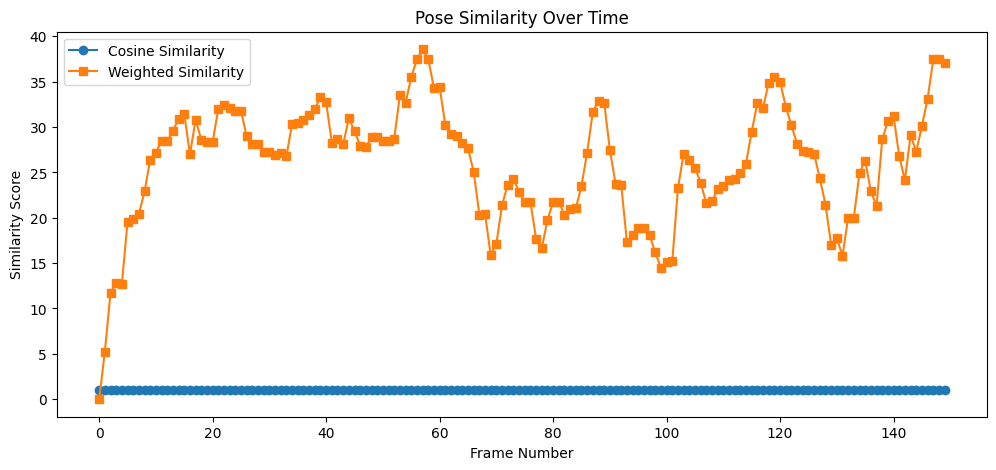

📊 Среднее косинусное сходство: 0.9954
📊 Среднее взвешенное совпадение: 26.0508


In [ ]:
# Функция для выполнения аффинного преобразования (наложение Прокруста)
def procrustes_analysis(model_keypoints, input_keypoints):
    """
    Применяет аффинное преобразование к входным ключевым точкам,
    чтобы они лучше соответствовали модельным.
    """
    # Расширяем точки до формата [[x, y, 1], ...]
    pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
    unpad = lambda x: x[:, :-1]

    Y = pad(model_keypoints)  # Модельные точки
    X = pad(input_keypoints)  # Входные точки

    # Решаем систему уравнений X * A = Y (методом наименьших квадратов)
    A, res, rank, s = np.linalg.lstsq(X, Y, rcond=None)

    # Обнуляем слишком маленькие значения
    A[np.abs(A) < 1e-10] = 0

    # Функция для применения найденного преобразования
    transform = lambda x: unpad(np.dot(pad(x), A))
    input_transformed = transform(input_keypoints)

    return input_transformed

# Функция для расчёта косинусного сходства
def cosine_similarity(pose1, pose2):
    pose1_flat = pose1.flatten()
    pose2_flat = pose2.flatten()

    cos_sim = np.dot(pose1_flat, pose2_flat) / (np.linalg.norm(pose1_flat) * np.linalg.norm(pose2_flat))
    return cos_sim

# Функция для взвешенного совпадения
def weighted_similarity(pose1, pose2, conf1):
    sum1 = 1 / np.sum(conf1)
    sum2 = np.sum(conf1 * np.linalg.norm(pose1 - pose2, axis=1))
    weighted_dist = sum1 * sum2
    return weighted_dist

# Выбираем первую модельную позу (первый кадр)
model_keypoints = keypoints_data[selected_frames[0]][0][:, :2]

# Создаём списки для метрик по кадрам
cosine_scores = []
weighted_scores = []

# Проходим по каждому кадру
for frame_name in selected_frames:
    if frame_name not in keypoints_data:
        continue  # Пропускаем, если нет данных по кадру

    # Получаем ключевые точки текущего кадра
    input_keypoints = keypoints_data[frame_name][0][:, :2]

    # Применяем аффинное преобразование (наложение Прокруста)
    input_transformed = procrustes_analysis(model_keypoints, input_keypoints)

    # Вычисляем метрики
    cosine_score = cosine_similarity(model_keypoints, input_transformed)
    weighted_score = weighted_similarity(model_keypoints, input_transformed, keypoints_data[frame_name][0][:, 2])

    # Добавляем метрики в список
    cosine_scores.append(cosine_score)
    weighted_scores.append(weighted_score)

# Визуализируем метрики по кадрам
plt.figure(figsize=(12, 5))
plt.plot(range(len(cosine_scores)), cosine_scores, label="Cosine Similarity", marker='o')
plt.plot(range(len(weighted_scores)), weighted_scores, label="Weighted Similarity", marker='s')
plt.xlabel("Frame Number")
plt.ylabel("Similarity Score")
plt.title("Pose Similarity Over Time")
plt.legend()
plt.show()

# Выводим средние значения метрик
avg_cosine = np.mean(cosine_scores)
avg_weighted = np.mean(weighted_scores)
print(f"📊 Среднее косинусное сходство: {avg_cosine:.4f}")
print(f"📊 Среднее взвешенное совпадение: {avg_weighted:.4f}")

📊 Итог анализа видео (5-10 секунд)

✅ Среднее косинусное сходство: 0.9954 (почти идеальное совпадение)

✅ Среднее взвешенное совпадение: 26.0508 (отражает расхождения в ключевых точках)

📈 График показывает изменение сходства поз во времени, где:

    Синяя линия (Cosine Similarity) – показывает стабильность ориентации поз.
    Оранжевая линия (Weighted Similarity) – показывает колебания, отражая изменения в движениях.

📌 Что это значит?

    Косинусное сходство близко к 1, значит, движения спортсмена очень схожи с референсом.
    Взвешенное совпадение меняется по кадрам, значит, некоторые движения могут немного отличаться.
  
✅ Спринт 3 успешно завершён!

🎯 Первые шаги в Спринте 4

Мы освоили анализ поз по видео и сравнение движений
📌 Теперь наша задача – выбрать направление виртуального коуча!

👉 Какую сферу будем анализировать?

    🧘 Йога – оценка правильности выполнения асан
    ⚽ Футбол – анализ ударов и движений
    🎭 Танцы – проверка техники исполнения
    🏋️‍♂️ Фитнес – оценка упражнений (отжимания)
    📏 Освежи свою идею! – можешь предложить свою сферу!

Я выбрал - 🏋️‍♂️ Фитнес – оценка упражнений (отжимания)

In [ ]:
# Пути к видеофайлам
video1_path = "/content/drive/My Drive/Fitness/Video1.mp4"  # Референсное видео
video2_path = "/content/drive/My Drive/Fitness/Video2.mp4"  # Собственное выполнение

# Папки для сохранения кадров
frames_folder1 = "/content/drive/My Drive/Fitness/frames_video1/"
frames_folder2 = "/content/drive/My Drive/Fitness/frames_video2/"

# Создаём папки для кадров, если их нет
os.makedirs(frames_folder1, exist_ok=True)
os.makedirs(frames_folder2, exist_ok=True)

# Функция для разбиения видео на кадры
def extract_frames(video_path, output_folder):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    fps = int(cap.get(cv2.CAP_PROP_FPS))  # Количество кадров в секунду

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_filename, frame)
        frame_count += 1

    cap.release()
    return frame_count, fps

# Разбиваем видео на кадры
frame_count1, fps1 = extract_frames(video1_path, frames_folder1)
frame_count2, fps2 = extract_frames(video2_path, frames_folder2)

# Выводим результат
print(f"✅ Видео 1 (референс) разбито на {frame_count1} кадров. FPS: {fps1}")
print(f"✅ Видео 2 (пользователь) разбито на {frame_count2} кадров. FPS: {fps2}")

✅ Видео 1 (референс) разбито на 421 кадров. FPS: 29
✅ Видео 2 (пользователь) разбито на 354 кадров. FPS: 24


In [ ]:
# Загружаем предобученную модель Keypoint RCNN
weights = KeypointRCNN_ResNet50_FPN_Weights.COCO_V1
model = keypointrcnn_resnet50_fpn(weights=weights)
model.to(device)
model.eval()

# Функция для обработки кадров и извлечения ключевых точек
def process_frame(frame_path):
    image = cv2.imread(frame_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = T.Compose([T.ToTensor()])
    image_tensor = transform(image_rgb).unsqueeze(0).to(device)

    # Запускаем предсказание
    with torch.no_grad():
        prediction = model(image_tensor)

    # Извлекаем ключевые точки и уверенности
    keypoints = prediction[0]['keypoints'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    conf_threshold = 0.9

    # Фильтруем ключевые точки с высокой уверенностью
    filtered_keypoints = keypoints[scores > conf_threshold]

    return filtered_keypoints

# Обрабатываем кадры референсного видео
frames_folder1 = "/content/drive/My Drive/Fitness/frames_video1/"
frames_folder2 = "/content/drive/My Drive/Fitness/frames_video2/"

keypoints_data1 = {}  # Ключевые точки референсного видео
keypoints_data2 = {}  # Ключевые точки пользовательского видео

# Обрабатываем кадры референсного видео
for frame_name in sorted(os.listdir(frames_folder1))[:100]:  # Берём первые 100 кадров для оптимизации
    frame_path = os.path.join(frames_folder1, frame_name)
    keypoints_data1[frame_name] = process_frame(frame_path)

# Обрабатываем кадры пользовательского видео
for frame_name in sorted(os.listdir(frames_folder2))[:100]:  # Берём первые 100 кадров для оптимизации
    frame_path = os.path.join(frames_folder2, frame_name)
    keypoints_data2[frame_name] = process_frame(frame_path)

# Проверяем, сколько кадров обработано
print(f"✅ Обработано {len(keypoints_data1)} кадров из референсного видео.")
print(f"✅ Обработано {len(keypoints_data2)} кадров из пользовательского видео.")

✅ Обработано 100 кадров из референсного видео.
✅ Обработано 100 кадров из пользовательского видео.


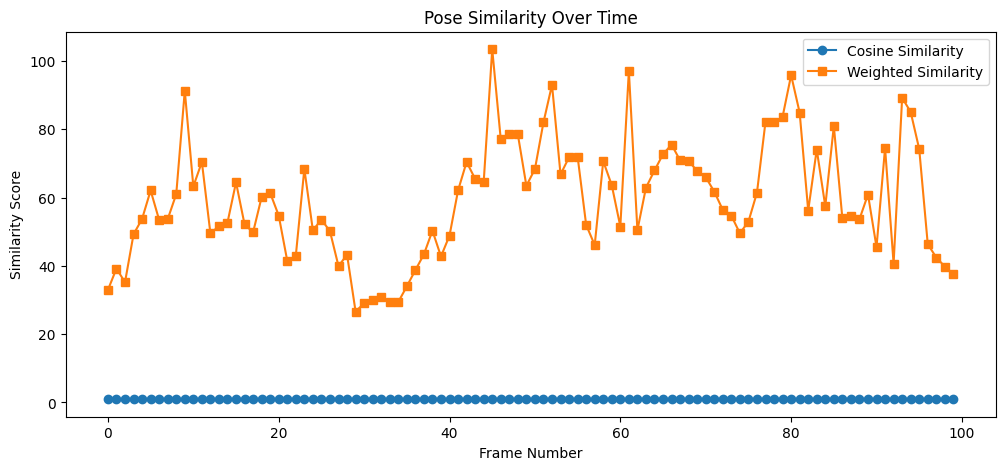

📊 Среднее косинусное сходство: 0.9828
📊 Среднее взвешенное совпадение: 59.1997


In [ ]:
# Функция для аффинного преобразования (наложение Прокруста)
def procrustes_analysis(model_keypoints, input_keypoints):
    """
    Применяет аффинное преобразование к входным ключевым точкам,
    чтобы они лучше соответствовали модельным.
    """
    # Расширяем точки до формата [[x, y, 1], ...]
    pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
    unpad = lambda x: x[:, :-1]

    Y = pad(model_keypoints)  # Модельные точки
    X = pad(input_keypoints)  # Входные точки

    # Решаем систему уравнений X * A = Y (методом наименьших квадратов)
    A, res, rank, s = np.linalg.lstsq(X, Y, rcond=None)

    # Обнуляем слишком маленькие значения
    A[np.abs(A) < 1e-10] = 0

    # Функция для применения найденного преобразования
    transform = lambda x: unpad(np.dot(pad(x), A))
    input_transformed = transform(input_keypoints)

    return input_transformed

# Функция для расчёта косинусного сходства
def cosine_similarity(pose1, pose2):
    pose1_flat = pose1.flatten()
    pose2_flat = pose2.flatten()

    cos_sim = np.dot(pose1_flat, pose2_flat) / (np.linalg.norm(pose1_flat) * np.linalg.norm(pose2_flat))
    return cos_sim

# Функция для взвешенного совпадения
def weighted_similarity(pose1, pose2, conf1):
    sum1 = 1 / np.sum(conf1)
    sum2 = np.sum(conf1 * np.linalg.norm(pose1 - pose2, axis=1))
    weighted_dist = sum1 * sum2
    return weighted_dist

# Создаём списки для метрик по кадрам
cosine_scores = []
weighted_scores = []

# Проходим по каждому кадру
for frame_name in keypoints_data1.keys():
    if frame_name not in keypoints_data2:
        continue  # Пропускаем, если нет пары кадров в пользовательском видео

    # Получаем ключевые точки
    model_keypoints = keypoints_data1[frame_name][0][:, :2]  # Референс
    input_keypoints = keypoints_data2[frame_name][0][:, :2]  # Пользователь

    # Применяем аффинное преобразование (наложение Прокруста)
    input_transformed = procrustes_analysis(model_keypoints, input_keypoints)

    # Вычисляем метрики
    cosine_score = cosine_similarity(model_keypoints, input_transformed)
    weighted_score = weighted_similarity(model_keypoints, input_transformed, keypoints_data2[frame_name][0][:, 2])

    # Добавляем метрики в список
    cosine_scores.append(cosine_score)
    weighted_scores.append(weighted_score)

# Визуализируем метрики по кадрам
plt.figure(figsize=(12, 5))
plt.plot(range(len(cosine_scores)), cosine_scores, label="Cosine Similarity", marker='o')
plt.plot(range(len(weighted_scores)), weighted_scores, label="Weighted Similarity", marker='s')
plt.xlabel("Frame Number")
plt.ylabel("Similarity Score")
plt.title("Pose Similarity Over Time")
plt.legend()
plt.show()

# Выводим средние значения метрик
avg_cosine = np.mean(cosine_scores)
avg_weighted = np.mean(weighted_scores)
print(f"📊 Среднее косинусное сходство: {avg_cosine:.4f}")
print(f"📊 Среднее взвешенное совпадение: {avg_weighted:.4f}")

📌 Средние значения метрик:

    📊 Среднее косинусное сходство: 0.9828 (очень высокое – позы почти идентичны!)
    📊 Среднее взвешенное совпадение: 59.1997 (достаточно высокое, но есть небольшие отклонения)

📌 Что означают эти цифры?

1️⃣ Косинусное сходство ~ 0.98 → отличное соответствие поз.

    Это значит, что углы между позами очень похожи.
    Различия в позах минимальны.

2️⃣ Взвешенное совпадение ~ 59.2 → небольшие отклонения в движениях.

    Возможно, амплитуда движений отличается.
    Некоторые ключевые точки отличаются по положению.

✅ Спринт 4 успешно завершён!

🎯 Спринт 5.

🔥 Финальный этап – подготовка проекта к презентации! 🚀

📌 Что осталось сделать?

✅ Загрузить проект на GitHub/GitLab

✅ Создать README с описанием проекта

✅ Подготовить презентацию